<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>Author: Yuriy Isakov

All the materials are distributed under [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. You may use these materials for any non-commercial purposes with obligatory referencing to the original source and author. Any commercial usage (complete or partial) is prohibited.

# <center> Assignment #4
## <center>  User Identification with Logistic Regression

Today we are going to practice working with sparse matrices, training Logistic Regression models, and composing and sorting features. We will reproduce two baselines for the ["Catch Me If You Can: Intruder Detection through Webpage Session Tracking"](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2)  Kaggle inclass competition. 

This assignment consists of nine tasks which you will need to perform. When you are finished, submit the [google-form](https://docs.google.com/forms/d/1dgk3zk-gjuJjazFZ3DTjMHvVhMbrzAuErufSpN6bxKA/edit) with your answers.

In [26]:
# we don't like warnings
# you can comment the following 2 lines if you'd like to
import warnings
warnings.filterwarnings('ignore')

# Import libraries 
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

##### Approaching the Problem
We will be solving the intruder detection problem by analyzing his behavior on the Internet. It is a complicated and interesting problem that combines data analysis and behavioral psychology.

For example, Yandex solves the mailbox intruder detection problem based on the user's behavior patterns based on the notion that the intruder's behaviour pattern might differ from the owner's: 
- the intruder might not delete emails right after they are read like the mailbox owner would
- the intruder might mark emails or move the cursor differently
- and more

Therefore, the intruder could be detected and thrown out from the mailbox, forcing the user to authenticate via SMS-code.
This pilot project is described in the Habrahabr article.

Similar things are being developed in Google Analytics and the research community. You can find more on this topic by searching for "Traversal Pattern Mining" and "Sequential Pattern Mining".

In this competition, we are going to solve a similar problem. Our algorithm needs to analyze the sequence of websites consequently visited by a particular person and predict whether this person is Alice or an intruder (someone else). We will measure [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). Stay tuned until the end of the course to find out who Alice is.

### 1. Data Downloading and Transformation
Register on [Kaggle](www.kaggle.com) if you have not done so before.
Go to the competition [page](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) and download the data.

First, read the training and test sets. Then, explore the data and perform a couple of simple exercises:

In [2]:
# Read the training and test data sets
train_df = pd.read_csv('../../data/websites_train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../../data/websites_test_sessions.csv',
                      index_col='session_id')

# Switch time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


The training dataset contains the following features:

- **site1** – id of the first visited website in the session
- **time1** – visiting time for the first website in the session
- ...
- **site10** – id of the tenth visited website in the session
- **time10** – visiting time for the tenth website in the session
- **target** – target variable, value 1 for Alice's sessions, and 0 otherwise
    
User sessions are chosen in such a way that they are no longer than half an hour and/or contain more than ten websites i.e. a session is considered ended if either a user has visited ten websites or a session has lasted for more than thirty minutes.

There are some empty values in the table, which means that these sessions contain less than ten websites. Replace empty values with 0, and change the columns' types to integer. Load the website's dictionary and see what it looks like:

In [3]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu



#### 4.1. What are the dimensions of the training and test sets (in exactly this order)?

- (82797, 20) and (253561, 20)
- (82797, 20) and (253561, 21)
- (253561, 21) and (82797, 20)
- (253561, 20) and (82797, 20)

In [4]:
print(train_df.shape)
print(test_df.shape)

(253561, 21)
(82797, 20)


### 2. Brief Exploratory Data Analysis

Before we start training models, we have to perform Exploratory Data Analysis ([EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis)). Today, we are going to perform a shorter version, but we will use other techniques as we move forward. Let's check which websites in the training data set are the most visited. As you can see, they are Google services and a bioinformatics website (a website with 'zero'-index is our missed values, just ignore it):

In [5]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].fillna(0).values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.loc[top_sites.index.tolist()]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
0,NaN
23,www.google.com
782,annotathon.org
22,apis.google.com


##### 4.2. What kind of websites does Alice visit the most?

- videohostings
- social networks
- torrent trackers
- news

In [6]:
# Your code is here
alice_df = train_df[train_df['target']==1]
alice_top = pd.Series(alice_df[sites].fillna(0).values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(alice_top)
sites_dict.loc[alice_top.index.tolist()]

#video hostings

77    1382
80    1354
76    1307
29     897
21     857
dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr


Now, let us look at the timestamps and try to characterize sessions by timeframes:

In [7]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In order to perform the next task, generate descriptive statistics as you did for the first homework in the first week.

##### 4.3. Select the correct statements (there can be none, one,.., all correct statements):

- on average, Alice's session is shorter than that of other users
- more than 1% of all sessions in the dataset belong to Alice
- minimum and maximum durations of Alice's and other users' sessions are approximately the same
- variation about the mean session duration for all users (including Alice) is approximately the same
- less than a quarter of Alice's sessions are greater than or equal to 40 seconds

In [22]:
# Your code is here
print(time_df.groupby('target')['seconds'].mean()) # alice session is shorter
print(time_df['target'].value_counts(normalize=True)) # alice < 1%
print(time_df.groupby('target')['seconds'].max())  # the same
print(time_df.groupby('target')['seconds'].min())# the same
print(time_df.groupby('target')['seconds'].std())  #variation not the same
alice_sessions = time_df[time_df['target']==1]
print(alice_sessions[alice_sessions['seconds']>=40].shape[0] / alice_sessions.shape[0]) # less than a quarter

target
0    139.282372
1     52.296474
Name: seconds, dtype: float64
0    0.990941
1    0.009059
Name: target, dtype: float64
target
0    1800.0
1    1763.0
Name: seconds, dtype: float64
target
0    0.0
1    0.0
Name: seconds, dtype: float64
target
0    296.653518
1    153.309014
Name: seconds, dtype: float64
0.2411841532433609


In order to train our first model, we need to prepare the data. First, exclude the target variable from the training set. Both training and test sets now have the same number of columns, and we can aggregate them into a single dataframe.  All transformations will therefore be performed simultaneously on both training and test data sets. 

On the one hand, this will lead to the fact that both data sets have one feature space (you don't have to worry that you forgot to transform a feature in some data sets). On the other hand, processing time will increase. 
For enormously large sets, it might be impossible to transform both data sets simultaneously, and you willhave to split your transformations into several stages across the train/test data set).
For this dataset, we are going to perform all the transformations for the whole combined dataframe at once and will filter the appropriate part before training the model or making predictions.

In [23]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

For the basic model, we will use only the visited websites in the session (but will not take into account the timestamp features). The point behind this data selection is: *Alice has her favorite sites. The more often you see these sites in the session, the higher the probability that this is Alice and vice versa.*

Now we'll prepare the data, taking only features `site1, site2, ... , site10` from the whole dataframe. Keep in mind that the missing values have been replaced with zero. Here is how the first rows of the dataframe should look:

In [24]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


Sessions are the sequences of website indices. This representation is inconvenient for linear methods. According to our hypothesis (Alice has favorite websites), we need to transform this dataframe so that each website has its corresponding feature (column) and that its value is equal to number of visits in the session. It can be accomplished with two lines of code:

In [25]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

If you understand what just happened here, then feel free to skip the next passage. If not, then let us figure it out.

### Lyrical Digression 1: Sparse Matrices

Let us estimate how much memory it will require to store our data from the example above. Our united dataframe contains 336k samples with 48k integer features each. We can roughly calculate the required amount of memory as follows:

$$336K * 48K * 8 bytes = 16M * 8 bytes = 128 GB,$$

(that's an [exact](http://www.wolframalpha.com/input/?i=336358*48371*8+bytes) value). Obviously, ordinary mortals do not have such volumes. (Python may allow you to create such a matrix, but it will not be easy to do anything with it.) However, recall that most of the elements in our matrix are zeros. If we count non-zero elements, then it will be only about 1.8 million, slightly more than 10% of the elements in the matrix. Such a matrix, where most elements are zeros, is considered sparse. The ratio between the number of zero elements and the total number of elements is called the sparseness of the matrix.

For working with such matrices, you can use the `scipy.sparse` library. Check [documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/sparse.html) to understand what possible types of sparse matrices there are, how to work with them, and in which cases their usage is most effective. You can learn how they are arranged, for example, in Wikipedia [article](https://en.wikipedia.org/wiki/Sparse_matrix).
Note that a sparse matrix stores only the non-zero elements, and you can get the allocated memory size by doing this (significant memory savings are obvious):

In [30]:
# How much memory does a sparse matrix occupy?
print('{0} elements * {1} bytes = {2} bytes'.format(full_sites_sparse.count_nonzero(), 8, 
                                                    full_sites_sparse.count_nonzero() * 8))
# Or just like this:
print('sparse_matrix_size = {0} bytes'.format(full_sites_sparse.data.nbytes))

1866898 elements * 8 bytes = 14935184 bytes
sparse_matrix_size = 7467592 bytes


Let us explore how the matrix with the websites was formed using a small example. Suppose we have the following table with user sessions:

| id | site1 | site2 | site3 |
|---|---|---|---|
| 1 | 1 | 0 | 0 |
| 2 | 1 | 3 | 1 |
| 3 | 2 | 3 | 4 |

There are 3 sessions with no more than 3 websites each. Users only visited four different sites in total (indexed as 1 to 4 in the table cells):

 1. vk.com
 2. habrahabr.ru 
 3. yandex.ru
 4. ods.ai

If the user has visited fewer than 3 websites during the session, the last few values will be zero. We want to convert the original dataframe in a way that each session has a corresponding row which shows the number of visits to each particular site i.e. we want to transform the previous table into the following form:

| id | vk.com | habrahabr.ru | yandex.ru | ods.ai |
|---|---|---|---|---|
| 1 | 1 | 0 | 0 | 0 |
| 2 | 2 | 0 | 1 | 0 |
| 3 | 0 | 1 | 1 | 1 |


To do this, use the constructor: `csr_matrix ((data, indices, indptr))` and create a frequency table (see examples, code, and comments in the links above to see how this works). Here we set all the parameters explicitly for greater clarity:

In [29]:
# data, create the list of ones, length of which equal to the number of elements in the initial dataframe (9)
# By summing the number of ones in the cell, we get the frequency,
# number of visits to a particular site per session
data = [1] * 9

# To do this, you need to correctly distribute the ones in cells
# Indices - website ids, i.e. columns of a new matrix. We will sum ones up grouping them by sessions (ids)
indices = [1, 0, 0, 1, 3, 1, 2, 3, 4]

# Indices for the division into rows (sessions)
# For example, line 0 is the elements between the indices [0; 3) - the rightmost value is not included
# Line 1 is the elements between the indices [3; 6)
# Line 2 is the elements between the indices [6; 9) 
indptr = [0, 3, 6, 9]

# Aggregate these three variables into a tuple and compose a matrix
# To display this matrix on the screen transform it into the usual "dense" matrix
csr_matrix((data, indices, indptr)).todense()

matrix([[2, 1, 0, 0, 0],
        [0, 2, 0, 1, 0],
        [0, 0, 1, 1, 1]])

As you might have noticed, there are not four columns in the resulting matrix (corresponding to number of different websites) but five. A zero column has been added, which indicates if the session was shorter (in our mini example we took sessions of three). This column is excessive and should be removed from the dataframe (do that yourself).

##### 4.4. What is the sparseness of the matrix in our small example?

- 42%
- 47%
- 50%
- 53%



In [43]:
# Your code is here
m = csr_matrix((data, indices, indptr))[:, 1:]
print(m.todense())
1- m.count_nonzero()/m.toarray().size

[[1 0 0 0]
 [2 0 1 0]
 [0 1 1 1]]


0.5

Another benefit of using sparse matrices is that there are special implementations of both matrix operations and machine learning algorithms for them, which sometimes allows significantly faster operations due to the data structure. This applies to logistic regression as well. Now everything is ready to build our first model.

### 3. Training the first model

We have an algorithm and data for it. Let's build our first model using the [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation from ` sklearn` with default parameters. We will use the first 90% of the data for training (sorted by time) and the remaining 10% for validation. Let's write a simple function that returns the quality of the model and then train our first classifier:

In [38]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [39]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.919524256796
Wall time: 9.05 s


The first model achieved an accuracy of 0.91952 on the validation set. The will be the first baseline and starting point. To make a prediction on the test data set, ** we need to train the model again on the entire training dataset ** Up until now, our model used only part of the data for training; this will now increase its generalizing ability:

In [40]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [41]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17).fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

If you follow these steps and upload the answer to the competition [page](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2), you will get `ROC AUC = 0.90812` on the public leaderboard.

### 4. Model Improvement: New Features Engineering

Now we are going to try to improve the quality of our model by adding new features to the data. But first, answer the following question:

##### 4.5. What years are present in the training and test datasets, respectively?

- 13 and 14
- 2012 and 2013
- 2013 and 2014
- 2014 and 2015

In [65]:
#np.array([x.year for x in ])
pd.Series(pd.to_datetime(train_df[times].values.flatten()).year).value_counts()

2014.0    1706973
2013.0     705907
dtype: int64

Create a feature that will be a number in YYYYMM format for the date when the session was held, for example 201407 -- year 2014 and 7th month. We will take into account the monthly [linear trend](http://people.duke.edu/~rnau/411trend.htm) for the entire period of the data provided.

In [66]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)

##### 4.6. Plot the graph of the number of Alice sessions versus the new feature, start_month. Choose the correct statement:

- Alice wasn't online at all for the entire period
- From the beginning of 2013 to mid-2014, the number of Alice's sessions per month decreased
- The number of Alice's sessions per month is generally constant for the entire period
- From the beginning of 2013 to mid-2014, the number of Alice's sessions per month increased

*Hint: the graph will be more explicit if you treat `start_month` as a categorical ordinal variable *.

In [74]:
# Your code is here
full_new_feat[y_train==1].groupby('start_month').size() #flase false flase true

start_month
201302     61
201304     38
201309    377
201311    446
201312    134
201401    129
201402    410
201403    400
201404    302
201405    229
201406     54
201407     83
201408     69
201409     37
201410     80
201411     84
201412    121
dtype: int64

Now we have an illustration and some intuition about the usefulness of this new feature. Add it to the training sample, and check the quality of the new model:

In [75]:
# Add the new feature to the sparse matrix
tmp = full_new_feat[['start_month']].as_matrix()
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.750835486018


The quality of the model has decreased significantly. We added a feature that definitely seemed useful to us, but it only made the model worse. Why did that happen?

### Lyrical Digression 2: is it necessary to scale the features?

Here we will use intuitive reasoning (you can easily find a rigorous mathematical justification for linear models on the internet). Consider the features more closely: those that correspond to the number of visits to a particular web-site per session vary from 0 to 10. The feature `start_month` has a completely different range, 201301 to 201412; this means the contribution from this variable is significantly greater than the others. It would seem that problem can be avoided if we put less weight on a linear combination of attributes in this case, but we are using logistic regression with regularization (by default, this parameter is `C = 1`), which penalizes the model the stronger its weights are. Therefore, for linear methods with regularization, it is recommended to convert features to the same scale (you can read more about regularization [here](https://habrahabr.ru/company/ods/blog/322076/)).

One way to do this is with standardization: for each observation you need to subtract the average value of the feature and divide the difference by the standard deviation:

$$ x^{*}_{i} = \dfrac{x_{i} - \mu_x}{\sigma_x}$$

Here are some practical tips:
- It is recommended to scale features if they have essentially different ranges or different units of measurement (for example, the country's population is in millions, and the country's GNP is in trillions)
- Scale features if you do not have a reason or opinion to give a greater weight to any of them
- Scaling can be excessive if the ranges of some of your features differ from each other but have the same units (for example, the proportion of middle-aged people and the proportion of people over 80)
- If you want to get an interpretable model, then build a model without regularization and scaling (most likely, its quality will be worse)
- Binary features (which take only values of 0 or 1) are usually left without conversion, but...
- If the quality of the model is crucial, try different options and select the one where the performance is better

Keeping this in mind, let's return to `start_month` and rescale the feature to train the model again. This time, we see that the quality has increased:

In [105]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.919683066316


##### 4.7. Add to the training set a new feature "n_unique_sites" – the number of the unique web-sites in a session. Calculate how the quality on the validation set has changed

- It has decreased. It is better not to add a new feature.
- It has not changed
- It has decreased. The new feature should be scaled.
- I am confused, and I do not know if it's necessary to scale a new feature.

*Tips: use the nunique() function from `pandas`. Do not forget to include the start_month in the set. Will you scale a new feature? Why?*

In [94]:
# Your code is here
full_new_feat['n_unique_sites'] = full_df[sites].apply(lambda row: row.nunique(), axis = 1, raw=False) 

st_month = StandardScaler().fit_transform(full_new_feat[['start_month']])

n_un_sites = full_new_feat[['n_unique_sites']].as_matrix()

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], st_month[:idx_split,:], n_un_sites[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.916343764039


So, the new feature has slightly decreased the quality, so we will not use it. Nevertheless, do not rush to throw features out because they haven't performed well. They can be useful in a combination with other features (for example, when a new feature is a ratio or a product of two others).

#####  4.8. Add two new features: start_hour and morning. Calculate the metric. Which of these features gives an improvement?

The `start_hour` feature is the hour at which the session started (from 0 to 23), and the binary feature `morning` is equal to 1 if the session started in the morning and 0 if the session started later (we assume that morning means `start_hour` is equal to 11 or less).

Will you scale the new features? Make your assumptions and test them in practice.

- None of the features gave an improvement :(
- `start_hour` feature gave an improvement, and `morning` did not
- `morning` feature gave an improvement, and `start_hour` did not
- Both features gave an improvement

*Tip: find suitable functions for working with time series data in [documentation](http://pandas.pydata.org/pandas-docs/stable/api.html). Do not forget to include the `start_month` feature.*

In [100]:
# Your code is here
full_new_feat['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour)
full_new_feat['morning'] = (full_new_feat['start_hour'] <= 11).astype(int)
full_new_feat.head()

,start_month,n_unique_sites,start_hour,morning
session_id,,,,
21669,201301,3,8,1
54843,201301,3,8,1
77292,201301,6,8,1
114021,201301,5,8,1
146670,201301,6,8,1


In [109]:
st_month = StandardScaler().fit_transform(full_new_feat[['start_month']])

#st_hour = full_new_feat[['start_hour']].as_matrix()
st_hour = StandardScaler().fit_transform(full_new_feat[['start_hour']])

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], st_month[:idx_split,:], st_hour[:idx_split,:]]))
print(get_auc_lr_valid(X_train, y_train))

0.957927478395


In [112]:
st_month = StandardScaler().fit_transform(full_new_feat[['start_month']])

morning = full_new_feat[['morning']].as_matrix()
#morning = StandardScaler().fit_transform(full_new_feat[['morning']])

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], st_month[:idx_split,:], st_hour[:idx_split,:], morning[:idx_split,:]]))
print(get_auc_lr_valid(X_train, y_train))

0.95911749308


### 5. Regularization and Parameter Tuning

We have introduced features that improve the quality of our model in comparison with the first baseline. Can we do even better? After we have changed the training and test sets, it almost always makes sense to search for the optimal hyperparameters - the parameters of the model that do not change during training.

For example, in week 3, you learned that, in decision trees, the depth of the tree is a hyperparameter, but the feature by which splitting occurs and its threshold is not. 

In the logistic regression taht we use, the weights of each feature are changing, and we find their optimal values during training; meanwhile, the regularization parameter remains constant. This is the hyperparameter that we are going to optimize now.

Calculate the quality on a validation set with a regularization parameter, which is equal to 1 by default:

In [113]:
# Compose the training set
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))

# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.959152062833


We will try to beat this result by optimizing the regularization parameter. We will take a list of possible values of $C$ and calculate the quality metric on the validation set for each of $C$-values:

In [114]:
from tqdm import tqdm

# List of possible C-values
Cs = np.logspace(-3, 1, 10)
scores = []
    
#for C in Cs:
#    scores.append(get_auc_lr_valid(X_train, y_train, C=C))



# Install and import this module to track the number of iterations performed 

from tqdm import tqdm
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 21.18s/it]


Wall time: 1min 54s


Plot the graph of the quality metric (AUC-ROC) versus the value of the regularization parameter. The value of quality metric corresponding to the default value of C=1 is represented by a horizontal dotted line:

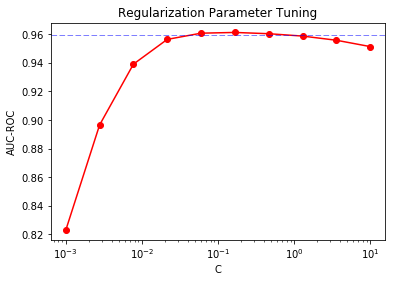

In [115]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
# horizontal line -- model quality with default C value
plt.axhline(y=score_C_1, linewidth=.5, color = 'b', linestyle='dashed') 
plt.show()

##### 4.9. What is the value of parameter C that corresponds to the highest model quality?

- 0.17
- 0.46
- 1.29
- 3.14

In [121]:
# Your code is here
C = Cs[np.argmax(scores)]
print(C)

0.16681005372


For the last task in this assignment: train the model using the optimal regularization parameter you found (do not round up to two digits like in the last question). If you do everything correctly and submit your solution, you should see 0.92784 on the public leaderboard:

In [122]:
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C, random_state=17).fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'baseline_2.csv')

### Conclusion

In this assignment, you have learned how to use sparse matrices, train logistic regression models, create new features and selected the best ones, learned why you need to scale features, and how to select hyperparameters. (That's a lot!)

Here are a few tips for finding new features: think about what you can come up with using existing features, try multiplying or dividing two of them, justify or decline your hypotheses with graphs, extract useful information from time series data (time1 ... time10), do not hesitate to convert an existing feature (for example, take a logarithm), etc. We encourage you to try new ideas and models throughout the course and participate in the competitions - it's fun!